# **Import Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import h5py
import numpy as np 
import cv2

# load all datasets from google drive
filepath = "/content/gdrive/My Drive/551-P3/MNIST_synthetic.h5"
h5 = h5py.File(filepath, 'r')
test_dataset = h5['test_dataset']
train_dataset = h5['train_dataset']
train_labels = h5['train_labels']

# **Apply Image Segmentation to One Image**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np 

# this function returns all segmented images in a list
def getPics(image, mode):

    # start by resizing the image
    image = cv2.resize(image, (320, 320)) 

    # apply threshhold
    thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY)[1]
    
    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # find all contours
    counts = cv2.findContours(morph,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 

    # get average area of each contour for later filtering
    meanCountArea = np.mean([cv2.contourArea(k) for k in cnts[0]])

    images = []
    countour_boxes = []

    # build boxes
    for (i,contour) in enumerate(counts[0]):
        if cv2.contourArea(c) < meanCountArea/2.4:
            continue
        (x,y,w,h) = cv2.boundingRect(contour)
        countour_boxes.append((x,y,w,h))

    # crop image and append to list
    for (x,y,w,h) in sorted(countour_boxes):
        # add padding to the bounding box to make image less pixelated
        crop_img = image[y-8:y+h+8, x-8:x+w+8]

        # resize the image to 28, 28 and change dimensions
        resized = cv2.copyMakeBorder(crop_img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, 255)
        resized = cv2.resize(resized, (28, 28))
        crop_img = np.reshape(resized,(28,28,1))
        images.append(crop_img)
        
    if mode == 0: return len(images)
    else: return images

# **Apply Image Segmentation to Multiple Images**

In [ ]:
# this loops through all images in the dataset to apply segmentation to each image one at a time
main = []
for i in range(len(test_dataset)):
  # print(i)
  images = getPics(test_dataset[i], 1)
  main.append(images)


# **Benchmark Performance of Image Segmentation**

In [ ]:
# this benchmark compares the length of the train sample and the amount of segmented digits to determine whether all digits were successfully segmentated

total_error_count = 0
under_error_count = 0
over_error_count = 0
images = []

# loop through all images in dataset
for i in range(len(train_dataset)):
  actual = train_labels[i]
  # remove 10's to have accurate length
  actual = [x for x in actual if x != 10]
  image = train_dataset[i]

  result = getPics(image, 0)
  actual = train_labels[i]

  if result > actual: over_error_count += 1
  if result < actual: under_error_count += 1
  if result != actual: total_error_count += 1

print("Accuracy of amount of digits in picture\nOut of", i + 1, "images, you got", total_error_count, "wrong\n")
print((i - total_error_count)/i*100, "% accuracy!")
print("under_count", under_error_count)
print("over_count", over_error_count)


# **Train/Validation on Original Provided Dataset**

In [ ]:
import cv2
import numpy as np
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def getPics(image):

    # start by resizing the image
    image = cv2.resize(image, (320, 320)) 

    # apply threshhold
    thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY)[1]
    
    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # find all contours
    counts = cv2.findContours(morph,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 

    # get average area of each contour for later filtering
    meanCountArea = np.mean([cv2.contourArea(k) for k in cnts[0]])

    images = []
    countour_boxes = []

    # build boxes
    for (i,contour) in enumerate(counts[0]):
        if cv2.contourArea(c) < meanCountArea/2.4:
            continue
        (x,y,w,h) = cv2.boundingRect(contour)
        countour_boxes.append((x,y,w,h))

    # crop image and append to list
    for (x,y,w,h) in sorted(countour_boxes):
        # add padding to the bounding box to make image less pixelated
        crop_img = image[y-8:y+h+8, x-8:x+w+8]

        # resize the image to 28, 28 and change dimensions
        resized = cv2.copyMakeBorder(crop_img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, 255)
        resized = cv2.resize(resized, (28, 28))
        crop_img = np.reshape(resized,(28,28,1))
        images.append(crop_img)
        
    return images

# import dataset
filepath = "./MNIST_synthetic.h5"
h5 = h5py.File(filepath, 'r')

test_dataset = h5['test_dataset']
train_dataset = h5['train_dataset']
train_labels = h5['train_labels']
main = []

# build list that holds all images
for i in range(len(test_dataset)):
    images = getPics(test_dataset[i])
    main.append(images)

# set up model training parameters
X_train = []
y_train = []

for i in range(len(main)):
    for j in range(len(main[i])):
        X_train.append(main[i][j])
        y_train.append(train_labels[i][j])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape, y_train.shape)


# set up model 
batch_size = 128
epochs = 40
num_models = 15
records = [0] * num_models
averages_train = [0]  * num_models
averages_validation = [0]  * num_models

model_names = ["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15"]
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=0, verbose=1, mode='min', baseline=None, restore_best_weights=True)
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.15,height_shift_range=0.15)
accuracy = [0] * num_models
model = [0] * num_models

# add all model parameters
for i in range(num_models):
    model[i] = Sequential()
    model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(rate=0.3))
    model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(rate=0.3))
    model[i].add(Flatten())
    model[i].add(Dense(128, activation='relu'))
    model[i].add(Dropout(rate=0.3))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

records = [[0] * epochs] * num_models

# start training each model
for i in range(num_models):
    X_val = X_train[0: int(X_train.shape[0]/4)]
    y_val = y_train[0:int(y_train.shape[0]/4)]
    X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
    y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]

    print(X_val.shape)
    print(y_val.shape)
    print(X_train_reduced.shape)
    print(y_train_reduced.shape)

    records[i] = model[i].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val), verbose = 1)
    print(" CNN ", i + 1, " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i].history['val_loss']), ".5f"))

# save each model
for i in range(num_models):
    model[i].save(model_names[i] + "2")

# output performance statistics
for i in range(num_models):
    averages_train[i] = max(records[i].history['accuracy'])
    averages_validation[i] = max(records[i].history['val_accuracy'])
t = 0
v = 0

# set up train/valiation
for i in range(num_models):
    t += averages_train[i]
    v += averages_validation[i]
t = t/num_models
v = v/num_models

print("Training Accuracy", t)
print("Validation Accuracy", v)

at = [[0] * epochs] * num_models
av = [[0] * epochs] * num_models

for i in num_models:
    at[i] = records[i].history['accuracy']
    av[i] = records[i].history['val_accuracy']

for i in range(num_models):
    at[i] = [x / num_models for x in at[i]]
    av[i] = [x / num_models for x in av[i]]

h5.close()

# plot graphs for accuracy and validation
plt.plot(list(range(1,epochs+1,1)), at)
plt.plot(list(range(1,epochs+1,1)), av)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(["Training Accuracy", "Validation Accuracy"], loc="upper left")
axes = plt.gca()
axes.set_ylim([0.95,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

# **Build Deep Neural Network I**

11493376/11490434 [==============================] - 0s 0us/step
Start Training...
Run Number:  1  Number of hidden layers:  1  Epochs Trained:  10  Training Accuracy:  0.99431  Validation Accuracy:  0.98840  Training Loss:  0.01876  Validation Loss:  0.04638
Run Number:  2  Number of hidden layers:  1  Epochs Trained:  10  Training Accuracy:  0.99444  Validation Accuracy:  0.98780  Training Loss:  0.01803  Validation Loss:  0.04824
Run Number:  3  Number of hidden layers:  1  Epochs Trained:  10  Training Accuracy:  0.99420  Validation Accuracy:  0.98780  Training Loss:  0.01823  Validation Loss:  0.04668
Run Number:  1  Number of hidden layers:  2  Epochs Trained:  10  Training Accuracy:  0.99716  Validation Accuracy:  0.98987  Training Loss:  0.01093  Validation Loss:  0.04742
Run Number:  2  Number of hidden layers:  2  Epochs Trained:  10  Training Accuracy:  0.99698  Validation Accuracy:  0.98940  Training Loss:  0.01108  Validation Loss:  0.04805
Run Number:  3  Number of hidden

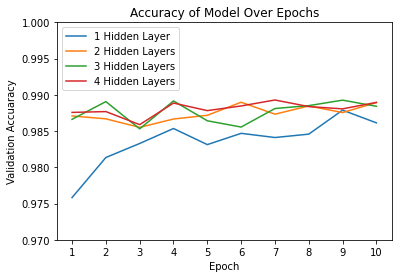

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 100
epochs = 10

#first test to see what is the best # of hidden layers between 1-4 for our model
sizes_tested = 4
model = [[0] * 3] * sizes_tested
model_names = ["1 Hidden Layer", "2 Hidden Layers", "3 Hidden Layers", "4 Hidden Layers" ]

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(sizes_tested):
  for j in range(3):
    if (i == 0):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=24, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
    
    if (i == 1):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=24, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))

    if (i == 2):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(24, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1), padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(48, kernel_size=(5,5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
      model[i][j].add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))

    if (i == 3):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=24, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Conv2D(filters=96, kernel_size=(5, 5), activation='relu', padding='same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))

    model[i][j].add(Flatten())
    model[i][j].add(Dense(256, activation='relu'))
    model[i][j].add(Dense(10, activation='softmax'))
    model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])] 
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])] 
records = [[0] * 3] * sizes_tested
averages = [[0] * epochs] * sizes_tested

#train it and print performance 
print("Start Training...")
for i in range(sizes_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit(X_train_reduced,y_train_reduced, epochs = epochs, batch_size=batch_size, validation_data = (X_val,y_val), verbose=0)
    print("Run Number: ", j+1, " Number of hidden layers: ", i+1, " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x,y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model architecture across epochs 
for i in range(sizes_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

From the graph produced from the code above we can determine that a model with 2 hidden layers is best as it's accuracy is similar to 3 or 4 hidden layers, but its training time will be significantly shorter

# **Build Deep Neural Network II**




In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard
history = History()

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 100
epochs = 15

#next we test to see what is the best # of filters for the two layer model
filters_tested = 5
model = [[0] * 3] * filters_tested
model_names = ["16 and 32 filters", "24 and 48 filters", "32 and 64 filters", "48 and 96 filters", "64 and 128 filters" ]
first_layer_filter_size = [16, 24, 32, 48, 64]
averages = [[0] * epochs] * filters_tested

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(filters_tested):
  for j in range(3):
    model[i][j] = Sequential()
    model[i][j].add(Conv2D(filters=first_layer_filter_size[i], kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Conv2D(filters=(first_layer_filter_size[i] * 2), kernel_size=(5, 5), activation='relu', padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Flatten())
    model[i][j].add(Dense(256, activation='relu'))
    model[i][j].add(Dense(10, activation='softmax'))
    model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]
records = [[0] * 3] * filters_tested
averages = [[0] * epochs] * filters_tested

#train it and print performance 
print("Start Training...")
for i in range(filters_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit(X_train_reduced,y_train_reduced, epochs = epochs, batch_size=batch_size, validation_data = (X_val,y_val), verbose=0)
    print ("Run:", j+1, " Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))


#print graphs of performance of different model architecture across epochs 
for i in range(filters_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()



KeyboardInterrupt: ignored

Based on the graph produced from the code above a model with 32 and 64 filters in its first two layers is ideal, as it perfromance is almost identical to the one with 64 ad 128 filters, but it's architectual simplicity will make training run much quicker

# **Build Deep Neural Network III**

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 100
epochs = 15

#next we test to see what is the best # of dense nodes to use in the last hidden layer
dense_nodes_tested = 5
model = [[0] * 3] * dense_nodes_tested
model_names = ["32 dense nodes", "64 dense nodes", "128 dense nodes", "256 dense nodes", "512 dense nodes", "1024 dense nodes" ]
averages = [[0] * epochs] * dense_nodes_tested

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(dense_nodes_tested):
  for j in range(3):
    model[i][j] = Sequential()
    model[i][j].add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Flatten())
    model[i][j].add(Dense(2**(5+i), activation='relu'))
    model[i][j].add(Dense(10, activation='softmax'))
    model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]
records = [[0] * 3] * dense_nodes_tested

#train it and print performance 
for i in range(dense_nodes_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit(X_train_reduced,y_train_reduced, epochs = epochs, batch_size=batch_size, validation_data = (X_val,y_val), verbose=0)
    print("Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model architecture across epochs 
for i in range(dense_nodes_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

KeyboardInterrupt: ignored

Based on the graph produced from the code above, the best performing number of dense nodes in the last hidden layer was 128 as it was just slightly less than 512, but would be much more efficient when trained

# **Build Deep Neural Network IV**

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 100
epochs = 15

#next we test to see what is the best dropout rate to use for the two layer model
dropout_tested = 5
model = [[0] * 3] * dropout_tested
model_names = [".20 dropout", ".25 dropout", ".30 dropout", ".35 dropout", ".40 dropout"]

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(dropout_tested):
  for j in range(3):
    model[i][j] = Sequential()
    model[i][j].add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Dropout(rate=(0.05*i + 0.20)))
    model[i][j].add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
    model[i][j].add(MaxPool2D(pool_size=(2, 2)))
    model[i][j].add(Dropout(rate=(0.05*i + 0.20)))
    model[i][j].add(Flatten())
    model[i][j].add(Dense(128, activation='relu'))
    model[i][j].add(Dropout(rate=(0.05*i + 0.20)))
    model[i][j].add(Dense(10, activation='softmax'))
    model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]
records = [[0] * 3] * dropout_tested
averages = [[0] * epochs] * dropout_tested

#train it and print performance 
for i in range(dropout_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit(X_train_reduced,y_train_reduced, epochs = epochs, batch_size=batch_size, validation_data = (X_val,y_val), verbose=0)
    print("Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model architecture across epochs 
for i in range(dropout_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()


11493376/11490434 [==============================] - 0s 0us/step


KeyboardInterrupt: ignored

The best performing dropout rate based on the above experiment was 0.3

# **Build Deep Neural Network V**





In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 100
epochs = 15

# next we test to see what is the best extra parameters to use for the two layer model
extra_tested = 8
model = [[0] * 3] * extra_tested
model_names = ["control", "3KS", "5F-2S", "BN", "DA", "3KS and 5F-2S", "All", "All and ES"]

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(extra_tested):
  for j in range(3):
    if (i == 0):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=(0.05 * i + 0.20)))
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 1):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 2):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 3):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28, 1), padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 4):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
      model[i][j].add(MaxPool2D(pool_size=(2, 2)))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 5):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(Conv2D(filters=64, kernel_size = ( 5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 6):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if (i == 7):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0] / 4)]
y_val = y_train[0:int(y_train.shape[0] / 4)]
X_train_reduced = X_train[int(X_train.shape[0] / 4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0] / 4):(X_train.shape[0])]
records = [[0] * 3] * extra_tested
averages = [[0] * epochs] * extra_tested
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.15, height_shift_range=0.15)

#train it and print performance 
print("Start training...")
for i in range(extra_tested):
  for j in range(3):
    if (i == 4 or i == 6):  # data augmentation
      records[i][j] = model[i][j].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))
      print("Run: ", j + 1, " Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ",
            format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"),
            " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ",
            format(min(records[i][j].history['val_loss']), ".5f"))
      averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

    elif (i == 7):  # data augmentation and early stopping
      callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=0, verbose=1, mode='min', baseline=None,
                                restore_best_weights=True)
      records[i][j] = model[i][j].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=batch_size),
                                          epochs=epochs, validation_data=(X_val, y_val))
      print("Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ",
            format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"),
            " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ",
            format(min(records[i][j].history['val_loss']), ".5f"))
      averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

    else:
      records[i][j] = model[i][j].fit(X_train_reduced, y_train_reduced, epochs=epochs, batch_size=batch_size,
                                validation_data=(X_val, y_val), verbose=0)
      print("Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ",
            format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ",
            format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ",
            format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ",
            format(min(records[i][j].history['val_loss']), ".5f"))
      averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model architecture across epochs 
for i in range(extra_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

The final model we choose is one with early stopping and the following architecture:  two 3 kernel layers in a row instead of one 5 kernel filter layer, with a 5 kernel filter with stride two instead of max pooling, with batch normalizationa and data augmentation. All we have left is to determine the best data augmentation hyper parameter to choose, the number of CNN's to train in parallel, and the best batch size

# **Build Deep Neural Network VI**




In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard


(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)

#next we test to see what is the best data augmentation parameters for our model are
batch_size = 100
epochs = 10
DA_tested = 9
model = [[0] * 3] * DA_tested
model_names = ["rr10-0.10", "rr10-0.15", "rr10-0.20", "rr15-0.10", "rr15-0.15", "rr15-0.20", "rr20-0.10", "rr20-0.15", "rr20-0.20"]
datagens = [0] * DA_tested
rr = 0
other = 0
i = 0

#build the different models, 3 of each type so we get an average across each parameter we're testing for
while(i < DA_tested):
  for j in range(3):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  if (i < 3):
    rot_range = 10
    if (i == 0):
        other = 0.1
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    elif (i == 1):
        other = 0.15
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    else:
        other = 0.2
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)

  if (i < 6 and i > 2):
    rot_range = 15
    if (i == 3):
        other = 0.1
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    elif (i == 4):
        other = 0.15
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    else:
        other = 0.2
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)

  if (i < 9 and i > 5):
    rot_range = 20
    if (i == 6):
        other = 0.1
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    elif (i == 7):
        other = 0.15
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
    else:
        other = 0.2
        datagens[i] = ImageDataGenerator(rotation_range=rr, zoom_range=other, width_shift_range=other,height_shift_range=other)
  i+=1

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]
records = [[0] * 3] * DA_tested
averages = [[0] * epochs] * DA_tested

#train it and print performance 
for i in range(DA_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit_generator(datagens[i].flow(X_train_reduced, y_train_reduced, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))
    print("Run: ", j + 1, " Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model architecture across epochs 
for i in range(DA_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

Based on the graph produced from the code above, the best data augmentation setup is the one with rotation range 15 and zoom range, width shift, and height shift 0.15

# **Build Deep Neural Network VII**

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_test = np.asarray(y_test, dtype=int)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)

#next we test to see what the best # of cnn's to average togther the predictions of is
batch_size = 100
epochs = 10
models_tested = 20
model = [0] * models_tested
model_names = list(range(1, models_tested + 1, 1))
predictions = np.zeros((X_test.shape[0], 10))
accuracy = [0] * models_tested
records = [0] * models_tested
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.15,height_shift_range=0.15)

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(models_tested):
  model[i] = Sequential()
  model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Dropout(rate=0.3))
  model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Dropout(rate=0.3))
  model[i].add(Flatten())
  model[i].add(Dense(128, activation='relu'))
  model[i].add(Dropout(rate=0.3))
  model[i].add(Dense(10, activation='softmax'))
  model[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#we set up the model architecture, now we have to train them
for i in range(models_tested):
    #split data into train and val sets before running each model
    X_val = X_train[0: int(X_train.shape[0] / 4)]
    y_val = y_train[0:int(y_train.shape[0] / 4)]
    X_train_reduced = X_train[int(X_train.shape[0] / 4):(X_train.shape[0])]
    y_train_reduced = y_train[int(X_train.shape[0] / 4):(X_train.shape[0])]

    records[i]= model[i].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=batch_size),
                                              epochs=epochs, validation_data=(X_val, y_val))
    print("CNN ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ",
          format(max(records[i].history['accuracy']), ".5f"), " Validation Accuracy: ",
          format(max(records[i].history['val_accuracy']), ".5f"), " Training Loss: ",
          format(min(records[i].history['loss']), ".5f"), " Validation Loss: ",
          format(min(records[i].history['val_loss']), ".5f"))

# sum predicted outputs across each of the individual models, then take max of the prediction
for i in range(models_tested):
  predictions += model[i].predict(X_test)
  correct = 0.0
  for j in range(y_test.shape[0]):
    if (np.argmax(y_test[j]) == np.argmax(predictions[j])):
      correct += 1
  accuracy[i] = correct / X_test.shape[0]
  print(i+1, " CNN's had an average test accuracy of ", accuracy[i])

#print graphs of performance of different # of models
plt.plot(list(range(1, models_tested + 1, 1)), accuracy)
plt.xlabel("Numer of CNN's Averaged Across")
plt.ylabel('Test Accuaracy')
plt.title('Test Accuracy of Multiple Models')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97, 1])
plt.xticks(list(range(1, models_tested + 1, 1)))
plt.show()

SyntaxError: ignored

The optimal number of CNN's to average together is 10, as they perfromed similarly in accuracy as 15-20 models, but would require a lot less computation

# **Build Deep Neural Network VIII**

In [ ]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)

#next we test to see what the optimal batch size is
batch_size = 100
epochs = 10
batches_tested = 5
model = [[0] * 3] * batches_tested
model_names = ["16 BS", "32 BS", "64 BS", "128 BS", "256 BS"]
batches = [0] * batches_tested

#build the different models, 3 of each type so we get an average across each parameter we're testing for
for i in range(batches_tested):
  for j in range(3):
      model[i][j] = Sequential()
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28,1), padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=32, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Conv2D(filters=64, kernel_size = (5, 5), strides = 2, activation = 'relu', padding = 'same'))
      model[i][j].add(BatchNormalization())
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Flatten())
      model[i][j].add(Dense(128, activation = 'relu'))
      model[i][j].add(Dropout(rate=0.3))
      model[i][j].add(Dense(10, activation='softmax'))
      model[i][j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#split data into train and val sets
X_val = X_train[0: int(X_train.shape[0]/4)]
y_val = y_train[0:int(y_train.shape[0]/4)]
X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])]
y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])]
records = [[0] * 3] * batches_tested
averages = [[0] * epochs] * batches_tested
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.15,height_shift_range=0.15)

#train it and print performance 
for i in range(batches_tested):
  for j in range(3):
    records[i][j] = model[i][j].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=(16*(i+1))), epochs=epochs, validation_data=(X_val, y_val))
    print("Run: ", j + 1, " Two layer CNN with: ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i][j].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i][j].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i][j].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i][j].history['val_loss']), ".5f"))
    averages[i] = list(x + y for (x, y) in zip(averages[i], records[i][j].history['val_accuracy']))

#print graphs of performance of different model batch sizes across epochs 
for i in range(batches_tested):
  averages[i] = [x / 3 for x in averages[i]]
  plt.plot(list(range(1,epochs+1,1)), averages[i])
print(averages)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuaracy')
plt.title('Accuracy of Model Over Epochs')
plt.legend(model_names, loc="upper left")
axes = plt.gca()
axes.set_ylim([0.97,1])
plt.xticks(list(range(1,epochs+1,1)))
plt.show()

The ideal batch size is 126 as it performed the best on the test above

# **Build Deep Neural Network IX**

In [ ]:
#train and test the final model
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.callbacks import TensorBoard

#set up final model parameters
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_rows, image_cols = 28, 28
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_test = np.asarray(y_test, dtype=int)
X_train = X_train.reshape(X_train.shape[0], image_rows, image_cols, 1)
X_test = X_test.reshape(X_test.shape[0], image_rows, image_cols, 1)
batch_size = 64
epochs = 50
num_models = 15
records = [0] * num_models
model_names = ["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15"]
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=0, verbose=1, mode='min', baseline=None, restore_best_weights=True) ##MIGHT USE depends on earlier test
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.15,height_shift_range=0.15)
predictions = np.zeros((X_test.shape[0],10))
accuracy = [0] * models_tested

#build the different number of models we're going to average across
for i in range(num_models):
  model[i] = Sequential()
  model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Dropout(rate=0.3))
  model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, activation='relu', padding='same'))
  model[i].add(BatchNormalization())
  model[i].add(Dropout(rate=0.3))
  model[i].add(Flatten())
  model[i].add(Dense(128, activation='relu'))
  model[i].add(Dropout(rate=0.3))
  model[i].add(Dense(10, activation='softmax'))
  model[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train/save models and print performance 
for i in range(num_models):
  #split data into train and val sets for each model
  X_val = X_train[0: int(X_train.shape[0]/4)]
  y_val = y_train[0:int(y_train.shape[0]/4)]
  X_train_reduced = X_train[int(X_train.shape[0]/4):(X_train.shape[0])] 
  y_train_reduced = y_train[int(X_train.shape[0]/4):(X_train.shape[0])] 
  records = [0] * models_tested
  
  records[i] = model[i].fit_generator(datagen.flow(X_train_reduced, y_train_reduced, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))
  print(" CNN ", model_names[i], " Epochs Trained: ", epochs, " Training Accuracy: ", format(max(records[i].history['accuracy']), ".5f"), " Validation Accuracy: ", format(max(records[i].history['val_accuracy']), ".5f"), " Training Loss: ", format(min(records[i].history['loss']), ".5f"), " Validation Loss: ", format(min(records[i].history['val_loss']), ".5f"))
  model[i].save(model_names[i])

432.46


# **Generate CSV File Based on Saved Trained Model**

In [ ]:
import keras
import numpy as np
import csv

model_names = ["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15"]
num_models = 15
model = [0] * num_models
PATH = "/content/gdrive/My Drive/files-forp3/andrei_models3/" 

# load saved models
for i in range(num_models):
    model[i] = keras.models.load_model(PATH + model_names[i])

# create csv file
with open('cheese3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Label"])

    for i in range(len(main)):
        image = main[i]
        image = np.array(image)

        # get best prediction across all models
        current = np.zeros((len(image), 10))
        for j in range(num_models):
            current += np.array(model[j](image,training=False))

        # create strings for each label
        curr = ""
        for k in range(current.shape[0]):
            curr += str(np.argmax(current[k]))

        # append missing 10's
        for m in range(5 - image.shape[0]):
            curr += "10"

        writer.writerow([i, curr])